From the paper: 
"Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis"
by Patrice Y. Simard, Dave Steinkraus, John C. Platt

Proceedings of the Seventh International Conference on Document Analysis and Recognition (ICDAR 2003)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 

In [3]:
device = torch.device('mps')

transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    '~/ML/data/', 
    train=True, 
    download=True,
    transform=transform,
)
train_dataset.data.to(device)
train_dataset.targets.to(device)


test_dataset = torchvision.datasets.MNIST(
    '~/ML/data/',
    train=False,
    download=True,
    transform=transform
)
test_dataset.data.to(device)
test_dataset.targets.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True 
)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


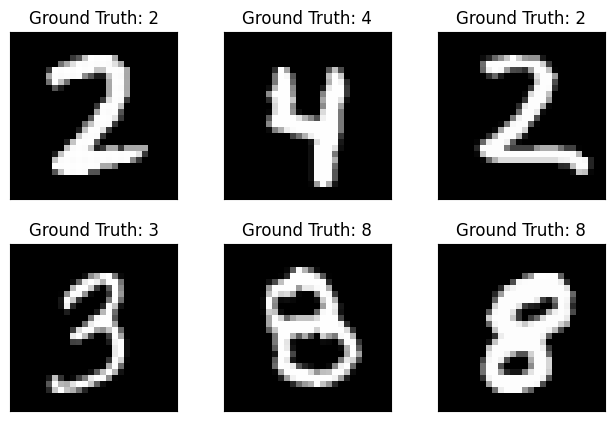

In [5]:
import matplotlib.pyplot as plt

def plotImages(n, data, targets, pred=None):
    fig = plt.figure()
    ncols = 3
    nrows = n//ncols
    for i in range(n):
      plt.subplot(nrows, ncols,i+1)
      plt.tight_layout()
      plt.imshow(data[i][0], cmap='gray', interpolation='none')
      if pred != None:
        plt.title("Ground Truth: {}| Pred:{}".format(targets[i], pred[i]))
      else:
        plt.title("Ground Truth: {}".format(targets[i]))
      plt.xticks([])
      plt.yticks([])
      fig
    
plotImages(6, example_data, example_targets)

In [6]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        input_dim = 28
        kernel_size = 5
        last_conv_out = ((input_dim - kernel_size + 1)/2 - kernel_size + 1) / 2
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=5, out_channels=50, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=int(pow(last_conv_out,2)*50), out_features=100, bias=True),
            nn.Linear(in_features=100, out_features=10, bias=True)
        )
        
    def forward(self, x):
        x = self.net(x)
        return F.log_softmax(x, dim =1)
    
network = MNISTNet().to(device)
learning_rate = 0.01
momentum = 0.5
optimizer = optim.Adam(network.parameters())

In [7]:
train_log_batch = 100
def train(epoch):
    network.train()
    total_loss = 0
    count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data.to(device))
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count+=target.shape[0]

        if (batch_idx+1) % train_log_batch == 0:
            print("\tTrain Batch: {} Loss: {:.6f}".format(batch_idx+1, total_loss/count))
            
    print('Train Epoch: {} Loss: {:.6f}\n'.format(epoch, total_loss/count))


In [8]:
bad_samples = []
def test():
    network.eval() 
    total_loss = 0
    total_correct = 0
    count = 0
    bad_samples = []
    for batch_idx, (data, target) in enumerate(test_loader):
        target=target.to(device)
        output = network(data.to(device))
        loss = F.nll_loss(output, target)
        total_loss += loss.item()
        
        pred = output.data.max(1).indices
        total_correct += (pred == target).sum()
        
        
        count+=target.shape[0]
    print('Test Accuracy: {:.4f}, Loss: {:.6f}\n'.format(total_correct/count*100, total_loss/count))

In [9]:
import timeit
timeit.timeit(lambda: test(), number=1 )

Test Accuracy: 14.6167, Loss: 0.002259



2.3158073750018957

In [10]:
n_epoch=12
test()
for epoch in range(1, n_epoch+1):
    train(epoch)
    test()

Test Accuracy: 14.6167, Loss: 0.002259



	Train Batch: 100 Loss: 0.011308


	Train Batch: 200 Loss: 0.007742


	Train Batch: 300 Loss: 0.006080


	Train Batch: 400 Loss: 0.005111


	Train Batch: 500 Loss: 0.004526


	Train Batch: 600 Loss: 0.004077


	Train Batch: 700 Loss: 0.003730


	Train Batch: 800 Loss: 0.003424


	Train Batch: 900 Loss: 0.003224


Train Epoch: 1 Loss: 0.003159



Test Accuracy: 97.8167, Loss: 0.000073



	Train Batch: 100 Loss: 0.001233


	Train Batch: 200 Loss: 0.001194


	Train Batch: 300 Loss: 0.001223


	Train Batch: 400 Loss: 0.001170


	Train Batch: 500 Loss: 0.001151


	Train Batch: 600 Loss: 0.001174


	Train Batch: 700 Loss: 0.001163


	Train Batch: 800 Loss: 0.001146


	Train Batch: 900 Loss: 0.001139


Train Epoch: 2 Loss: 0.001147



Test Accuracy: 97.9617, Loss: 0.000063



	Train Batch: 100 Loss: 0.000794


	Train Batch: 200 Loss: 0.000815


	Train Batch: 300 Loss: 0.000822


	Train Batch: 400 Loss: 0.000859


	Train Batch: 500 Loss: 0.000863


	Train Batch: 600 Loss: 0.000890


	Train Batch: 700 Loss: 0.000876


	Train Batch: 800 Loss: 0.000886


	Train Batch: 900 Loss: 0.000886


Train Epoch: 3 Loss: 0.000883



Test Accuracy: 98.7650, Loss: 0.000038



	Train Batch: 100 Loss: 0.000740


	Train Batch: 200 Loss: 0.000765


	Train Batch: 300 Loss: 0.000741


	Train Batch: 400 Loss: 0.000724


	Train Batch: 500 Loss: 0.000707


	Train Batch: 600 Loss: 0.000698


	Train Batch: 700 Loss: 0.000725


	Train Batch: 800 Loss: 0.000745


	Train Batch: 900 Loss: 0.000744


Train Epoch: 4 Loss: 0.000749



Test Accuracy: 98.8283, Loss: 0.000035



	Train Batch: 100 Loss: 0.000526


	Train Batch: 200 Loss: 0.000636


	Train Batch: 300 Loss: 0.000608


	Train Batch: 400 Loss: 0.000636


	Train Batch: 500 Loss: 0.000618


	Train Batch: 600 Loss: 0.000615


	Train Batch: 700 Loss: 0.000631


	Train Batch: 800 Loss: 0.000640


	Train Batch: 900 Loss: 0.000657


Train Epoch: 5 Loss: 0.000664



Test Accuracy: 98.8200, Loss: 0.000035



	Train Batch: 100 Loss: 0.000485


	Train Batch: 200 Loss: 0.000513


	Train Batch: 300 Loss: 0.000591


	Train Batch: 400 Loss: 0.000590


	Train Batch: 500 Loss: 0.000584


	Train Batch: 600 Loss: 0.000581


	Train Batch: 700 Loss: 0.000567


	Train Batch: 800 Loss: 0.000573


	Train Batch: 900 Loss: 0.000586


Train Epoch: 6 Loss: 0.000584



Test Accuracy: 99.1083, Loss: 0.000027



	Train Batch: 100 Loss: 0.000404


	Train Batch: 200 Loss: 0.000411


	Train Batch: 300 Loss: 0.000442


	Train Batch: 400 Loss: 0.000438


	Train Batch: 500 Loss: 0.000462


	Train Batch: 600 Loss: 0.000472


	Train Batch: 700 Loss: 0.000493


	Train Batch: 800 Loss: 0.000495


	Train Batch: 900 Loss: 0.000503


Train Epoch: 7 Loss: 0.000512



Test Accuracy: 98.6667, Loss: 0.000041



	Train Batch: 100 Loss: 0.000373


	Train Batch: 200 Loss: 0.000379


	Train Batch: 300 Loss: 0.000421


	Train Batch: 400 Loss: 0.000423


	Train Batch: 500 Loss: 0.000447


	Train Batch: 600 Loss: 0.000449


	Train Batch: 700 Loss: 0.000450


	Train Batch: 800 Loss: 0.000472


	Train Batch: 900 Loss: 0.000468


Train Epoch: 8 Loss: 0.000469



Test Accuracy: 99.1300, Loss: 0.000026



	Train Batch: 100 Loss: 0.000414


	Train Batch: 200 Loss: 0.000391


	Train Batch: 300 Loss: 0.000394


	Train Batch: 400 Loss: 0.000395


	Train Batch: 500 Loss: 0.000392


	Train Batch: 600 Loss: 0.000381


	Train Batch: 700 Loss: 0.000390


	Train Batch: 800 Loss: 0.000404


	Train Batch: 900 Loss: 0.000413


Train Epoch: 9 Loss: 0.000421



Test Accuracy: 99.3900, Loss: 0.000018



	Train Batch: 100 Loss: 0.000327


	Train Batch: 200 Loss: 0.000351


	Train Batch: 300 Loss: 0.000363


	Train Batch: 400 Loss: 0.000361


	Train Batch: 500 Loss: 0.000350


	Train Batch: 600 Loss: 0.000340


	Train Batch: 700 Loss: 0.000339


	Train Batch: 800 Loss: 0.000346


	Train Batch: 900 Loss: 0.000362


Train Epoch: 10 Loss: 0.000369



Test Accuracy: 99.2417, Loss: 0.000022



	Train Batch: 100 Loss: 0.000272


	Train Batch: 200 Loss: 0.000251


	Train Batch: 300 Loss: 0.000298


	Train Batch: 400 Loss: 0.000336


	Train Batch: 500 Loss: 0.000326


	Train Batch: 600 Loss: 0.000334


	Train Batch: 700 Loss: 0.000345


	Train Batch: 800 Loss: 0.000346


	Train Batch: 900 Loss: 0.000357


Train Epoch: 11 Loss: 0.000363



Test Accuracy: 99.5133, Loss: 0.000015



	Train Batch: 100 Loss: 0.000219


	Train Batch: 200 Loss: 0.000248


	Train Batch: 300 Loss: 0.000252


	Train Batch: 400 Loss: 0.000281


	Train Batch: 500 Loss: 0.000302


	Train Batch: 600 Loss: 0.000292


	Train Batch: 700 Loss: 0.000298


	Train Batch: 800 Loss: 0.000299


	Train Batch: 900 Loss: 0.000308


Train Epoch: 12 Loss: 0.000308



Test Accuracy: 99.4733, Loss: 0.000015



In [42]:
pred = network(example_data.to(device)).max(1).indices

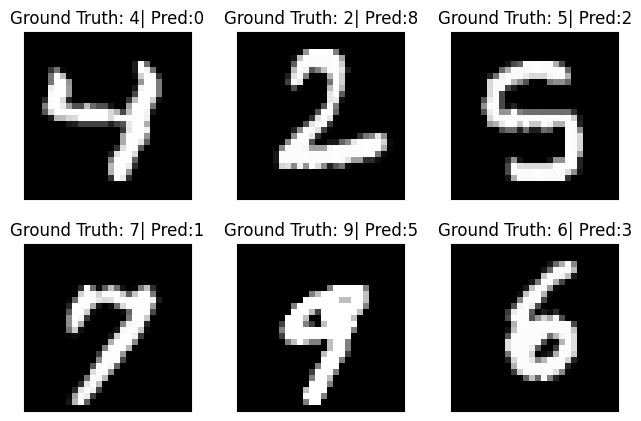

In [20]:
idxs = pred != example_targets.to(device)
plotImages(6, example_data.to(device)[idxs].to('cpu'), example_targets.to(device)[idxs].to('cpu'), pred[idxs].to('cpu'))